In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=Warning)

# Return Forecasting: Time Series Analysis & Modelling with CAD-PHY Exchange rate data.
In this notebook, you will load historical Canadian Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [2]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [3]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


# Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

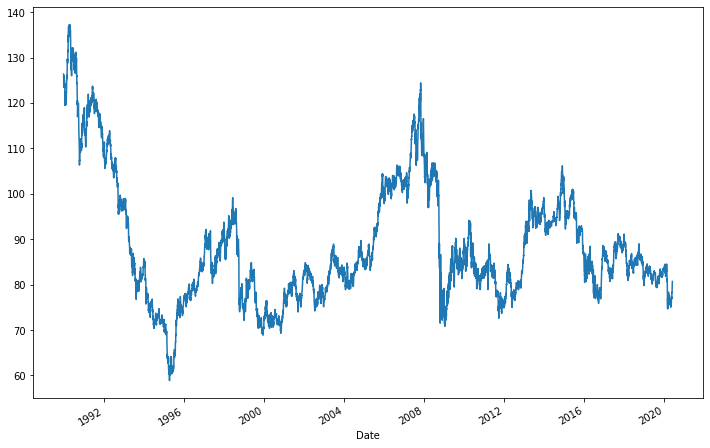

In [4]:
# Plot just the "Price" column from the dataframe:
cad_jpy_plot = cad_jpy_df.Price.plot(figsize=(12,8))

**Question:** Do you see any patterns, long-term and/or short? 

**Answer:** Apart from what seem like an 8-year cycle of relatively larger spikes immediately prior to or just around 1992, 2000, 2008 and 2016, there are no distinct patterns that can be gleaned from the chart.

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the exchange rate price into trend and noise.

In [5]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the exchange rate price into two separate series:
ts_noise, ts_trend = sm.tsa.filters.hpfilter(cad_jpy_df['Price'])

In [6]:
# Create a dataframe of just the exchange rate price, and add columns for "noise" and "trend" series from above:
cad_jpy_df['Noise']=ts_noise
cad_jpy_df['Trend']=ts_trend
cad_jpy_df

,Price,Open,High,Low,Noise,Trend
Date,,,,,,
1990-01-02,126.37,126.31,126.37,126.31,0.519095,125.850905
1990-01-03,125.30,125.24,125.30,125.24,-0.379684,125.679684
1990-01-04,123.46,123.41,123.46,123.41,-2.048788,125.508788
1990-01-05,124.54,124.48,124.54,124.48,-0.798304,125.338304
1990-01-08,124.27,124.21,124.27,124.21,-0.897037,125.167037
...,...,...,...,...,...,...
2020-05-29,78.29,78.21,78.41,77.75,-0.503961,78.793961
2020-06-01,79.27,78.21,79.36,78.04,0.218939,79.051061
2020-06-02,80.40,79.26,80.56,79.15,1.088117,79.311883


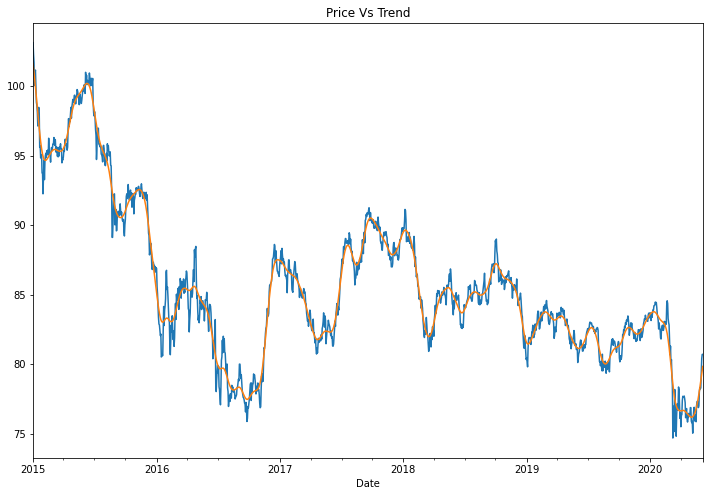

In [7]:
# Plot the Exchange Rate Price vs. the Trend for 2015 to the present
price_trend_plot= cad_jpy_df.loc['2015':].Price.plot()
price_trend_plot= cad_jpy_df.loc['2015':].Trend.plot(figsize=(12,8)).set_title('Price Vs Trend')

**Question:** Do you see any patterns, long-term and/or short?

**Answer:** There appears to be no distinct long or short-term pattern that can be gleaned.

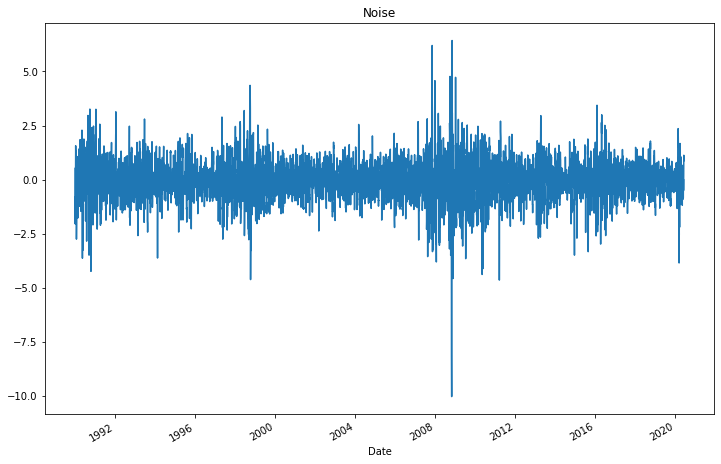

In [8]:
# Plot the Settle Noise
noise_plot=cad_jpy_df.Noise.plot(figsize=(12,8)).set_title('Noise')

---

# Forecasting Returns using an ARMA Model

Using exchange rate *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [9]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (cad_jpy_df[["Price"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Price
Date,
2020-05-29,0.076697
2020-06-01,1.251756
2020-06-02,1.425508
2020-06-03,0.373134
2020-06-04,0.012392


In [10]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA

# Estimate and ARMA model using statsmodels (use order=(2, 1))
ARMA_model = ARMA(returns.values, order=(2,1))

# Fit the model and assign it to a variable called results
results = ARMA_model.fit()

In [11]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7928
Model:                     ARMA(2, 1)   Log Likelihood               -9751.978
Method:                       css-mle   S.D. of innovations              0.828
Date:                Tue, 26 Apr 2022   AIC                          19513.955
Time:                        18:41:23   BIC                          19548.846
Sample:                             0   HQIC                         19525.903
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.009     -0.245      0.807      -0.020       0.016
ar.L1.y       -0.8547      0.164     -5.201      0.000      -1.177      -0.533
ar.L2.y       -0.0197      0.013     -1.475      0.140      -0.046       0.006
ma.L1.y        0.8246      0.164      5.031      0.000       0.503       1.146
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2033           +0.0000j            1.2033            0.5000
AR.2          -42.1697           +0.0000j           42.1697            0.5000
MA.1           -1.2127           +0.0000j            1.2127            0.5000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 Day Returns Forecast'}>

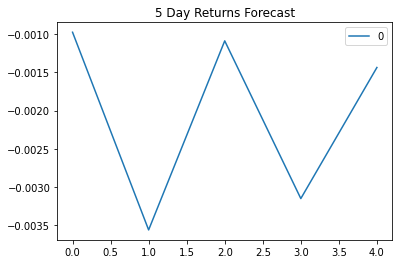

In [12]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title='5 Day Returns Forecast')

**Question:** Based on the p-value, is the model a good fit?

**Answer:** Given that the p-value of this model is greater than the 0.05 threshold, it is likely to be an unreliable coefficient that might cause misleading results.

---

# Forecasting the Exchange Rate Price using an ARIMA Model

 1. Using the *raw* CAD/JPY exchange rate price, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Plot a 5 day forecast for the Exchange Rate Price. What does the model forecast predict will happen to the Japanese Yen in the near term?

In [29]:
# from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
arima_model = ARIMA(cad_jpy_df['Price'], order=(5,1,1))

# Fit the model
results1 = arima_model.fit()

C:\Users\Wai Fatt Yee\anaconda3\envs\py37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Wai Fatt Yee\anaconda3\envs\py37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Wai Fatt Yee\anaconda3\envs\py37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [30]:
# Output model summary results:
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                 7929
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -8745.898
Date:                Tue, 26 Apr 2022   AIC                          17505.796
Time:                        18:51:06   BIC                          17554.643
Sample:                             0   HQIC                         17522.523
                               - 7929                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4303      0.331      1.299      0.194      -0.219       1.080
ar.L2          0.0178      0.012      1.459      0.145      -0.006       0.042
ar.L3         -0.0117      0.009     -1.313      0.189      -0.029       0.006
ar.L4          0.0110      0.008      1.299      0.194      -0.006       0.028
ar.L5         -0.0191      0.007     -2.706      0.007      -0.033      -0.005
ma.L1         -0.4583      0.332     -1.380      0.167      -1.109       0.192
sigma2         0.5318      0.004    118.418      0.000       0.523       0.541
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              9233.72
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                            -0.58
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
pd.DataFrame(results1.forecast(steps=5))

C:\Users\Wai Fatt Yee\anaconda3\envs\py37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


,predicted_mean
7929,80.704250
7930,80.692163
7931,80.668492
7932,80.652548
7933,80.645153


C:\Users\Wai Fatt Yee\anaconda3\envs\py37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


<AxesSubplot:title={'center':'5 Day Futures Price Forecast'}>

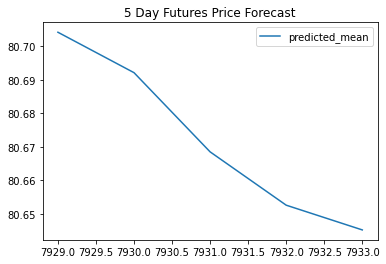

In [32]:
# Plot the 5 Day Price Forecast
pd.DataFrame(results1.forecast(steps=5)).plot(title='5 Day Futures Price Forecast')

**Question:** What does the model forecast will happen to the Japanese Yen in the near term?

**Answer:** The model forecasts the Japanese Yen to be on a downtrend in the near term.

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen exchange rate returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using exchange rate *Returns*, estimate a GARCH model. **Hint:** You can reuse the `returns` variable from the ARMA model section.

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [37]:
from arch import arch_model

In [38]:
# Estimate a GARCH model:
garch_model = arch_model(returns, mean='Zero', vol='GARCH', p=2, q=1)

# Fit the model
result2 = garch_model.fit(disp='off')

In [39]:
# Summarize the model results
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8911.02
Distribution:                  Normal   AIC:                           17830.0
Method:            Maximum Likelihood   BIC:                           17858.0
                                        No. Observations:                 7928
Date:                Tue, Apr 26 2022   Df Residuals:                     7928
Time:                        18:58:18   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      9.0733e-03  2.545e-03      3.566  3.628e-04  [4.086e-03,1.406e-02]
alpha[1]       0.0624  1.835e-02      3.402  6.682e-04  [2.647e-02,9.841e-02]
alpha[2]       0.0000  2.010e-02      0.000      1.000 [-3.940e-02,3.940e-02]
beta[1]        0.9243  1.229e-02     75.205      0.000      [  0.900,  0.948]
=============================================================================

Covariance estimator: robust
"""

**Note:** Our p-values for GARCH and volatility forecasts tend to be much lower than our ARMA/ARIMA return and price forecasts. In particular, here we have all p-values of less than 0.05, except for alpha(2), indicating overall a much better model performance. In practice, in financial markets, it's easier to forecast volatility than it is to forecast returns or prices. (After all, if we could very easily predict returns, we'd all be rich!)

In [40]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2020-06-04'

In [41]:
# Create a 5 day forecast of volatility
forecast_horizon = 5

# Start the forecast using the last_day calculated above
forecasts = result2.forecast(start='2020-6-4', horizon=forecast_horizon)
forecasts

In [42]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2020-06-04,12.566029,12.573718,12.581301,12.588778,12.596153


In [43]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2020-06-04
h.1,12.566029
h.2,12.573718
h.3,12.581301
h.4,12.588778
h.5,12.596153


<AxesSubplot:>

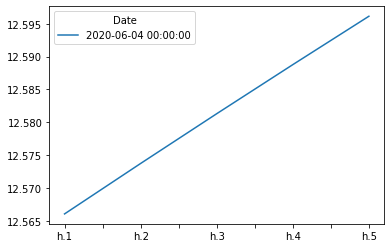

In [44]:
# Plot the final forecast
final.plot()

**Question:** What does the model forecast will happen to volatility in the near term?

**Answer:** YOUR ANSWER HERE

---

# Conclusions

1. Based on your time series analysis, would you buy the yen now?

    * Among the 3 models, ARIMA has the lowest AIC and BIC which suggests it is the better performing model. Based on the forecast using the ARIMA model, the Japanese Yen is expected to decline in the short-term hence, I will not be buying the Yen anytime soon.

2. Is the risk of the yen expected to increase or decrease?
    * Based on the ARIMA model, the risk of the Japanese Yen is expected to increase in the near term.

3. Based on the model evaluation, would you feel confident in using these models for trading?
    * These models are simplistic in the assumptions taken to forecast often ignoring other qualitative factors that might impact the movement of price. I will not feel confident by using these models alone instead, they should be used in conjunction with other forecasting tools to corroborate. 